In [1]:
from Augmented_SSM import Augmented_SSM
import numpy as np
import pandas as pd
from dateutil import tz
from astral import Astral
from Utilities import *
from ModelTest import loadTestSets

In [8]:
colors = 2*[c["color"] for c in plt.rcParams["axes.prop_cycle"]]

# Simple tests

In [51]:
def gen_data(dt, Omega, Q, R, pi1, sigma1, T):
    """Generate data from a 1D augmented state space model.
    
    Args:
        dt (float): timestep
        Omega (1 x 1 numpy.array): nonzero component of the observation matrix. C is defined as (Omega 0).
        Q (2 x 2 numpy.array): hidden state noise covariance
        R (1 x 1 numpy.array): observation noise covariance
        pi1 (2 x 1 numpy.array): initial hidden state mean
        sigma1 (2 x 2 numpy.array): initial hidden state uncertainty
        T (int): number of observations/timesteps
        
    Returns:
        2 x T numpy.array, 1 x T numpy.array: hidden state and observation values
    
    """
    
    A = np.array([[1.0, dt], [0.0, 1.0]])
    
    x = np.zeros([2, T])
    x[:, 0] = np.random.normal(pi1, sigma1).flatten()
    
    for t in range(1, T):
        x[:, t] = np.dot(A, x[:, t-1]) + np.random.multivariate_normal(mean=[0, 0], cov=Q)

    # y_t = C x_t + delta, delta ~ N(0, R)
    y = np.dot(Omega, x[0:1, :]) + np.random.normal(loc=0, scale=R, size=[1, T])
    
    return x, y

## Scenario 1

In [91]:
dt = 0.25

Omega_1 = np.array([1.0]).reshape([1, 1])
Q_1 = 0.1 * np.identity(2)
R_1 = np.array([0.1]).reshape([1, 1])
pi1_1 = np.array([0.0, -0.1]).reshape([2, 1])
sigma1_1 = np.array([0.05]).reshape([1, 1])
T_1 = 100

x_1, y_1 = gen_data(dt, Omega_1, Q_1, R_1, pi1_1, sigma1_1, T_1)

### Augmented SSM EM

In [92]:
aug_ssm_1 = Augmented_SSM(y_1, dt, 1, v=np.zeros([1, T_1]))
aug_ssm_1.em(100)

# Get observation estimates and error band
y_hat_1 = aug_ssm_1.get_y_hat()
y_em_err_1 = np.einsum("ij,ki,tjk->it", aug_ssm_1.Cs[0], aug_ssm_1.Cs[0].T, aug_ssm_1.sigma_smooth)

# Print parameters
#aug_ssm_1.print_params()

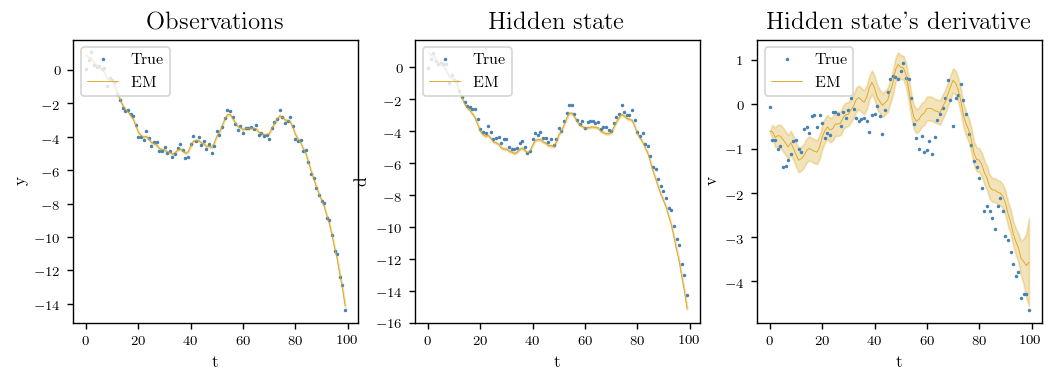

In [95]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 3, 1)

# Plot data
plt.plot(y_1.T, '.', color=colors[0], markersize=2, label="True")

# Plot smoothed state computed using EM
plt.plot(y_hat_1.T, color=colors[2], label="EM", linewidth=0.5)
plt.fill_between(range(T_1),
                 (y_hat_1 - 2*y_em_err_1).flatten().T,
                 (y_hat_1 + 2*y_em_err_1).flatten().T,
                 linewidth=1,
                 alpha=0.3,
                 color=colors[2])

plt.title("Observations")
plt.xlabel("t")
plt.ylabel("y")
plt.legend(loc="upper left")

########################

plt.subplot(1, 3, 2)

# Plot true hidden state
plt.plot(x_1[0, :].T, '.', color=colors[0], markersize=2, label="True")

# Plot infered hidden state with error bars
plt.plot(aug_ssm_1.x_smooth[0, :].T, color=colors[2], linewidth=0.5, label="EM")
plt.fill_between(range(T_1),
                 (aug_ssm_1.x_smooth[0, :] - 2*aug_ssm_1.sigma_smooth[:, 0, 0]).flatten().T,
                 (aug_ssm_1.x_smooth[0, :] + 2*aug_ssm_1.sigma_smooth[:, 0, 0]).flatten().T,
                 linewidth=1,
                 alpha=0.3,
                 color=colors[2])

plt.title("Hidden state")
plt.xlabel("t")
plt.ylabel("d")
plt.legend(loc="upper left")

########################

plt.subplot(1, 3, 3)

# Plot true hidden state's derivative
plt.plot(x_1[1, :].T, '.', color=colors[0], markersize=2, label="True")
# Plot infered hidden state's derivative
plt.plot(aug_ssm_1.x_smooth[1, :].T, color=colors[2], linewidth=0.5, label="EM")
plt.fill_between(range(T_1),
                 (aug_ssm_1.x_smooth[1, :] - 2*aug_ssm_1.sigma_smooth[:, 1, 1]).flatten().T,
                 (aug_ssm_1.x_smooth[1, :] + 2*aug_ssm_1.sigma_smooth[:, 1, 1]).flatten().T,
                 linewidth=1,
                 alpha=0.3,
                 color=colors[2])

plt.title("Hidden state's derivative")
plt.xlabel("t")
plt.ylabel("v")
plt.legend(loc="upper left")

### Compare with Kalman smoother

In [100]:
# Plug in true parameter values
aug_ssm_1.Bs = np.array([np.array([0]).reshape([1, 1])])
aug_ssm_1.Cs = np.array([np.asarray(np.bmat([Omega_1, np.zeros([1, 1])]))])
aug_ssm_1.Ds = np.array([np.array([0]).reshape([1, 1])]) # no sensor bias
aug_ssm_1.Qs = np.array([Q_1])
aug_ssm_1.Rs = np.array([R_1])
aug_ssm_1.pi1 = pi1_1.flatten()
aug_ssm_1.sigma1 = sigma1_1

# Run smoother
aug_ssm_1.smooth()
y_smooth = np.einsum("ij,jt->it", aug_ssm_1.Cs[0], aug_ssm_1.x_smooth)
y_smooth_err = np.einsum("ij,ki,tjk->it", aug_ssm_1.Cs[0], aug_ssm_1.Cs[0].T, aug_ssm_1.sigma_smooth)

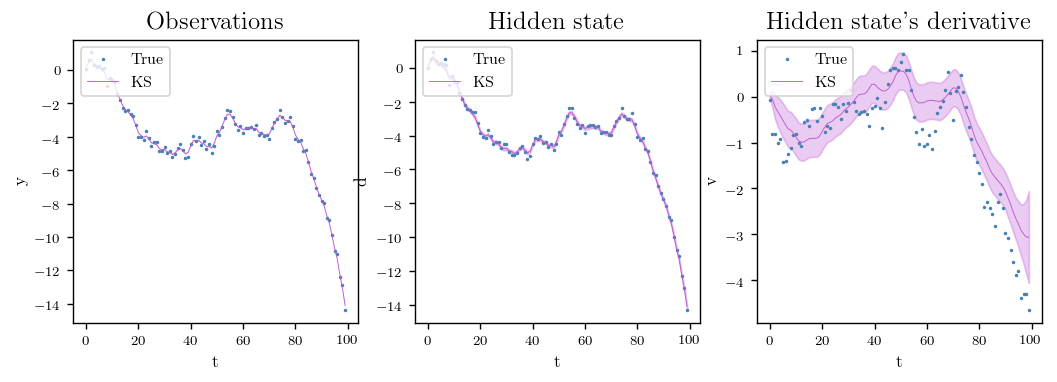

In [106]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 3, 1)

# Plot data
plt.plot(y_1.T, '.', color=colors[0], markersize=2, label="True")

# Plug in true parameter values
aug_ssm_1.Bs = np.array([np.array([0]).reshape([1, 1])])
aug_ssm_1.Cs = np.array([np.asarray(np.bmat([Omega_1, np.zeros([1, 1])]))])
aug_ssm_1.Ds = np.array([np.array([0]).reshape([1, 1])]) # no sensor bias
aug_ssm_1.Qs = np.array([Q_1])
aug_ssm_1.Rs = np.array([R_1])
aug_ssm_1.pi1 = pi1_1.flatten()
aug_ssm_1.sigma1 = sigma1_1

# Plot smoothed state and error band
plt.plot(y_smooth.T, color=colors[3], linewidth=0.5, label="KS")
plt.fill_between(range(T_1),
                 (y_smooth - y_smooth_err).flatten().T,
                 (y_smooth + y_smooth_err).flatten().T,
                 linewidth=0,
                 alpha=0.3,
                 color=colors[3])


plt.title("Observations")
plt.xlabel("t")
plt.ylabel("y")
plt.legend(loc="upper left")

########################

plt.subplot(1, 3, 2)

# Plot true hidden state
plt.plot(x_1[0, :].T, '.', color=colors[0], markersize=2, label="True")

# Plot infered hidden state with error bars
plt.plot(aug_ssm_1.x_smooth[0, :].T, color=colors[3], linewidth=0.5, label="KS")
plt.fill_between(range(T_1),
                 (aug_ssm_1.x_smooth[0, :] - 2*aug_ssm_1.sigma_smooth[:, 0, 0]).flatten().T,
                 (aug_ssm_1.x_smooth[0, :] + 2*aug_ssm_1.sigma_smooth[:, 0, 0]).flatten().T,
                 linewidth=1,
                 alpha=0.3,
                 color=colors[3])

plt.title("Hidden state")
plt.xlabel("t")
plt.ylabel("d")
plt.legend(loc="upper left")

########################

plt.subplot(1, 3, 3)

# Plot true hidden state's derivative
plt.plot(x_1[1, :].T, '.', color=colors[0], markersize=2, label="True")
# Plot infered hidden state's derivative
plt.plot(aug_ssm_1.x_smooth[1, :].T, color=colors[3], linewidth=0.5, label="KS")
plt.fill_between(range(T_1),
                 (aug_ssm_1.x_smooth[1, :] - 2*aug_ssm_1.sigma_smooth[:, 1, 1]).flatten().T,
                 (aug_ssm_1.x_smooth[1, :] + 2*aug_ssm_1.sigma_smooth[:, 1, 1]).flatten().T,
                 linewidth=1,
                 alpha=0.3,
                 color=colors[3])

plt.title("Hidden state's derivative")
plt.xlabel("t")
plt.ylabel("v")
plt.legend(loc="upper left")

## Scenario 2: one change point

In [ ]:
# Regime a
Omega_2a = np.array([1.0]).reshape([1, 1])
Q_2a = 0.1 * np.identity(2)
R_2a = np.array([0.1]).reshape([1, 1])
pi1_2a = np.array([0.0, 0.1]).reshape([2, 1])
sigma1_2a = np.array([0.05]).reshape([1, 1])
T_2a = 50

x_2a, y_2a = gen_data(dt, Omega_2a, Q_2a, R_2a, pi1_2a, sigma1_2a, T_2a)

# Regime b
Omega_2b = np.array([1.0]).reshape([1, 1])
Q_2b = 0.1 * np.identity(2)
R_2b = np.array([0.1]).reshape([1, 1])
pi1_2b = np.array([0.0, 0.1]).reshape([2, 1])
sigma1_2b = np.array([0.05]).reshape([1, 1])
T_2b = 50

x_2b, y_2b = gen_data(dt, Omega_2b, Q_2b, R_2b, pi1_2b, sigma1_2b, T_2b)

In [4]:
T_2a = 50
A_2a = np.array([1.075]).reshape([1, 1])
C_2a = np.array([1.0]).reshape([1, 1])
Q_2a = np.array([0.1]).reshape([1, 1])
R_2a = np.array([0.1]).reshape([1, 1])
pi1_2a = np.array([0.0]).reshape([1, 1])
sigma1_2a = np.array([0.1]).reshape([1, 1])

x_2a, y_2a = gen_data(A_2a, C_2a, Q_2a, R_2a, pi1_2a, sigma1_2a, T_2a)

# Switch regimes!
T_2b = 75
A_2b = np.array([1.0]).reshape([1, 1])
C_2b = np.array([1.0]).reshape([1, 1])
Q_2b = np.array([0.65]).reshape([1, 1])
R_2b = np.array([0.65]).reshape([1, 1])
pi1_2b = np.array(x_2a[:, -1]).reshape([1, 1])
sigma1_2b = R_2a

x_2b, y_2b = gen_data(A_2b, C_2b, Q_2b, R_2b, pi1_2b, sigma1_2b, T_2b)

# Append data
T_2 = T_2a + T_2b
x_2 = np.zeros([1, T_2])
x_2[:, 0:T_2a] = x_2a
x_2[:, T_2a:] = x_2b
y_2 = np.zeros([1, T_2])
y_2[:, 0:T_2a] = y_2a
y_2[:, T_2a:] = y_2b

# Switching variable
ss_2 = np.zeros(T_2, dtype=int)
ss_2[T_2a:] = 1

In [5]:
ssm_2 = SSM(y_2, 1, v=np.zeros([1, T_2]), ss=ss_2)
ssm_2.em(100)

# Get observation estimates and error band
y_hat_2 = ssm_2.get_y_hat()
y_em_err_2 = np.einsum("ij,ki,tjk->it", ssm_2.Cs[0], ssm_2.Cs[0], ssm_2.sigma_smooth)

ssm_2.print_params()

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


A_0 = [[ 0.89655086]]
B_0 = [[ 0.]]
C_0 = [[ 0.07593246]]
D_0 = [[ 0.]]
R_0 = [[ 0.00823297]]


A_1 = [[ 0.99012719]]
B_1 = [[ 0.]]
C_1 = [[ 0.75775953]]
D_1 = [[ 0.]]
R_1 = [[ 0.30825377]]


pi_1 = [ 1.03861264]
sigma_1 = [[ 0.02310104]]


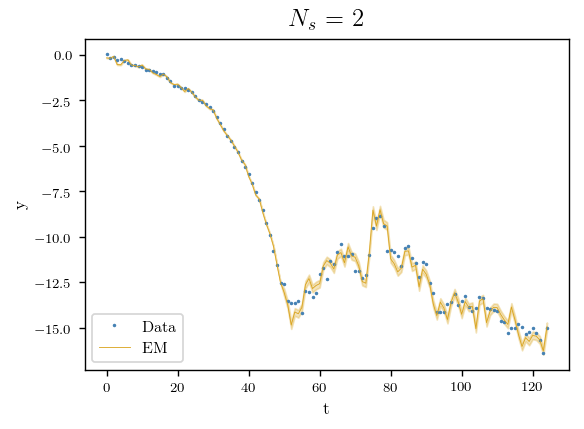

In [436]:
# Plot data
#plt.plot(y_2.T, 'xr', markersize=2)
plt.plot(range(T_2a), np.einsum("ij,jt->it", C_2a, x_2a).T, '.', color=colors[0], markersize=2, label="Data")
plt.plot(range(T_2a, T_2a+T_2b), np.einsum("ij,jt->it", C_2b, x_2b).T, '.', color=colors[0], markersize=2)

# Plot smoothed state computed using EM
plt.plot(y_hat_2.T, color=colors[2], label="EM", linewidth=0.5)
plt.fill_between(range(T_2),
                 (y_hat_2 - 2*y_em_err_2).flatten().T,
                 (y_hat_2 + 2*y_em_err_2).flatten().T,
                 linewidth=1,
                 alpha=0.3,
                 color=colors[2])

plt.title(r"$N_s$ = %i" % ssm_2.N_s)
plt.xlabel("t")
plt.ylabel("y")
plt.legend(loc="lower left")

# Tests on real data

## Load Feather data

In [3]:
# Info on what's available
feather_wsns = ["KTL", "GRZL"]

# Choose a network
df_feather_ktl = pd.read_csv("../raw_data/feather_data/%s.csv" % feather_wsns[0])

# Extract values
y_sd_raw = df_feather_ktl[["snowdepth_%i" % s for s in range(1, 12)]].values
y_t_raw = df_feather_ktl[["air_temp_%i" % s for s in range(1, 12)]].values
y_rh_raw = df_feather_ktl[["rel_humidity_%i" % s for s in range(1, 12)]].values
y_rad_raw = df_feather_ktl["solar_rad_8"].values
times = pd.to_datetime(df_feather_ktl["time"])

# Convert times to CA ones
utc_zone = tz.gettz("UTC")
ca_zone = tz.gettz("America/Los_Angeles")
times = np.array([t.replace(tzinfo=utc_zone).astimezone(ca_zone) for t in times])

# Get dawn/dusk times

def get_dawn_dusk(ts):
    a = Astral()
    a.solar_depression = "civil"
    city = a["Sacramento"]
    
    return np.array([city.sun(t)["sunrise"] for t in ts]), np.array([city.sun(t)["sunset"] for t in ts])

## Set up and run SSM

### Setup

In [8]:
# Choose some data
ti, tf = 16700, 16850
sensors = [0, 1, 3, 4, 5, 6, 7, 8, 9, 10]
y = y_sd_raw[ti:tf, sensors].T # note the transpose!

# Set controls
u = np.zeros([1, tf-ti])
v = np.ones([1, tf-ti]) # should be ones

# Discrete state
ss = np.zeros(tf-ti, dtype=int)
s_list = [0]

# Set number of latent factors
n_LF = 2

ssm = SSM(y, u, v, ss, s_list, n_LF)

### Run

In [5]:
# Maximum number of EM iterations
max_it = 1

# Run EM!
ssm.em(max_it)
y_hat = ssm.get_y_hat()

## Stable SSM EM

### Setup

In [4]:
n_LF = 2
sensors = [0, 1, 3, 4, 5, 6, 7, 8, 9, 10]

ti, tf = 16700, 16850
Y = y_sd_raw[ti:tf, sensors].T

# Set controls
U = np.zeros([1, tf-ti])
V = np.ones([1, tf-ti]) # should be ones

# Discrete state
ss = np.zeros(tf-ti, dtype=int)
s_list = [0]

### Run

In [7]:
max_it = 1

X_hat, sigma_smooth, sigma_filt, pi0, sigma0, As, Bs, Cs, Ds, Qs, Rs = ssm_em_stable(Y, U, V, ss, s_list, n_LF, max_it)
Y_hat = np.dot(Cs[0], X_hat) + np.dot(Ds[0], V)

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Sigma_{T,T-1} [[ 0.00925317 -0.0036831 ]
 [-0.00255985  0.01369061]]
J[148]:  [[ 0.10089598 -0.02770625]
 [-0.03994777  0.14894687]]
J[147]:  [[ 0.0867899   0.01717749]
 [ 0.00870814  0.07237333]]
J[146]:  [[ 0.08684748  0.0171268 ]
 [ 0.00864769  0.07249206]]
J[145]:  [[ 0.09688458  0.00426627]
 [-0.00593098  0.10114371]]
J[144]:  [[ 0.08468116  0.00277494]
 [-0.00648684  0.08567675]]
J[143]:  [[ 0.07881938  0.01187952]
 [ 0.00392659  0.06978955]]
J[142]:  [[ 0.10832516 -0.02234069]
 [-0.03490603  0.1525929 ]]
J[141]:  [[ 0.07874111  0.01199621]
 [ 0.00406091  0.06958931]]
J[140]:  [[ 0.09298227  0.00390394]
 [-0.0055183   0.10232621]]
J[139]:  [[ 0.08473222  0.00281251]
 [-0.00645157  0.08569953]]
J[138]:  [[ 0.086752    0.01707243]
 [ 0.00860112  0.07246437]]
J[137]:  [[ 0.08525308 -0.00127638]
 [-0.01027941  0.09881703]]
J[136]:  [[ 0.08672117  0.01712974]
 [ 0.00866403  0.0723444 ]]
J[135]:  [[ 0.07877058  0.01184048]
 [ 0.00388896  0.0697636 ]]
J[134]:  [[ 0.10101138 -0.02800043]

## Compare results numerically
They agree!

### PCA estimate
Agree!

In [10]:
pca_est_MD(Y, n_LF, max_it=10)

(array([[ 0.81912551,  0.41561373],
        [ 1.03437532,  0.83990684],
        [ 0.85313246, -1.48618626],
        [ 1.32302611,  0.69923642],
        [ 0.73228735,  0.24566252],
        [ 1.02216974,  0.59010055],
        [ 1.18676997,  0.40255799],
        [ 0.83597325, -1.82954911],
        [ 0.80392412, -1.5001562 ],
        [ 1.20259055,  0.50576703]]),
 array([[ 1742.97599792,  1743.58848966,  1741.34218964,  1740.64719033,
          1735.34092425,  1737.26341388,  1749.06209265,  1597.86171643,
          1754.25243307,  1742.80373036,  1755.36703934,  1746.39766734,
          1744.75335907,  1743.34336423,  1618.70867847,  1740.3759148 ,
          1742.80917066,  1612.95342387,  1743.69814246,  1745.06029135,
          1738.40500266,  1738.54400659,  1740.08851433,  1752.30462784,
          1751.58266142,  1740.31513078,  1756.98924951,  1627.62173151,
          1614.60849548,  1613.10956942,  1743.62263718,  1749.53364085,
          1750.14040572,  1591.57294004,  1758.8937533

In [11]:
ssm.pca_est_MD(num_it=10)

(array([[ 0.81912551,  0.41561373],
        [ 1.03437532,  0.83990684],
        [ 0.85313246, -1.48618626],
        [ 1.32302611,  0.69923642],
        [ 0.73228735,  0.24566252],
        [ 1.02216974,  0.59010055],
        [ 1.18676997,  0.40255799],
        [ 0.83597325, -1.82954911],
        [ 0.80392412, -1.5001562 ],
        [ 1.20259055,  0.50576703]]),
 array([[ 1742.97599792,  1743.58848966,  1741.34218964,  1740.64719033,
          1735.34092425,  1737.26341388,  1749.06209265,  1597.86171643,
          1754.25243307,  1742.80373036,  1755.36703934,  1746.39766734,
          1744.75335907,  1743.34336423,  1618.70867847,  1740.3759148 ,
          1742.80917066,  1612.95342387,  1743.69814246,  1745.06029135,
          1738.40500266,  1738.54400659,  1740.08851433,  1752.30462784,
          1751.58266142,  1740.31513078,  1756.98924951,  1627.62173151,
          1614.60849548,  1613.10956942,  1743.62263718,  1749.53364085,
          1750.14040572,  1591.57294004,  1758.8937533

### Kalman filter predict and update steps
Agree!

In [8]:
kf = Kalman(pi0, sigma0, As[0], Bs[0], Cs[0], Ds[0], Qs[0], Rs[0])

nan_ss = np.where(np.isnan(y[:, 0]))[0]
kf.C[nan_ss, :] = 0.0
kf.D[nan_ss, :] = 0.0
kf.R[nan_ss, :] = 0.0
kf.R[:, nan_ss] = 0.0
kf.R[nan_ss, nan_ss] = 1.0

kf.predict(U[:, 1])
print kf.mu, "\n"
print kf.sigma, "\n\n"

kf.update(np.nan_to_num(y[:, 1]), V[:, 1])
print kf.mu, "\n"
print kf.sigma

[ 1747.6673709   -208.75306922] 

[[ 1.58424698 -0.11774222]
 [-0.11774222  1.83945588]] 


[ 1747.83860919  -208.67161557] 

[[ 1.5531792  -0.1314948 ]
 [-0.1314948   1.83334547]]


In [9]:
ssm.As = As
ssm.Bs = Bs
ssm.Cs = Cs
ssm.Ds = Ds
ssm.Qs = Qs
ssm.Rs = Rs
ssm.pi1 = pi0
ssm.sigma1 = sigma0

ssm.filter()

ssm._kf_predict(1)
print ssm.x_pred[:, 0], "\n"
print ssm.sigma_pred[0], "\n\n"

ssm._kf_update(1)
print ssm.x_filt[:, 1], "\n"
print ssm.sigma_filt[1]

[ 1747.6673709   -208.75306922] 

[[ 1.58424698 -0.11774222]
 [-0.11774222  1.83945588]] 


[ 1747.83860919  -208.67161557] 

[[ 1.5531792  -0.1314948 ]
 [-0.1314948   1.83334547]]


### Kalman filter/smoother
Smoothers disagree

#### Setup

In [10]:
smoothed_results = kalman_smooth(Y, U, V, ss, pi0, sigma0, As, Bs, Cs, Ds, Qs, Rs)

Sigma_{T,T-1} [[  7.3651225   -1.64198379]
 [ -1.82284533  11.62291886]]
J[148]:  [[ 0.89358803 -0.03403354]
 [-0.01800064  0.94920244]]
J[147]:  [[ 0.89409245 -0.03382139]
 [-0.01778454  0.94929292]]
J[146]:  [[ 0.89473465 -0.03354631]
 [-0.01750416  0.94941257]]
J[145]:  [[ 0.89555124 -0.03319063]
 [-0.01714147  0.94957006]]
J[144]:  [[ 0.89179088 -0.03470847]
 [-0.01868572  0.94894747]]
J[143]:  [[ 0.89180165 -0.03470708]
 [-0.01868438  0.94894755]]
J[142]:  [[ 0.89181527 -0.03470494]
 [-0.01868229  0.94894777]]
J[141]:  [[ 0.89183252 -0.03470177]
 [-0.01867917  0.94894823]]
J[140]:  [[ 0.89185438 -0.03469723]
 [-0.01867465  0.94894904]]
J[139]:  [[ 0.89188212 -0.03469082]
 [-0.01866826  0.94895037]]
J[138]:  [[ 0.89191734 -0.03468192]
 [-0.01865936  0.94895246]]
J[137]:  [[ 0.89196211 -0.03466973]
 [-0.01864712  0.94895563]]
J[136]:  [[ 0.89201904 -0.03465316]
 [-0.01863045  0.94896029]]
J[135]:  [[ 0.89209149 -0.03463083]
 [-0.01860794  0.94896702]]
J[134]:  [[ 0.89218375 -0.03460

In [11]:
ssm.As = As
ssm.Bs = Bs
ssm.Cs = Cs
ssm.Ds = Ds
ssm.Qs = Qs
ssm.pi1 = pi0
ssm.sigma1 = sigma0

ssm.smooth()

Sigma_{T,T-1} [[  7.3651225   -1.64198379]
 [ -1.82284533  11.62291886]]
J[148]:  [[ 0.89358803 -0.03403354]
 [-0.01800064  0.94920244]]
J[147]:  [[ 0.89409245 -0.03382139]
 [-0.01778454  0.94929292]]
J[146]:  [[ 0.89473465 -0.03354631]
 [-0.01750416  0.94941257]]
J[145]:  [[ 0.89555124 -0.03319063]
 [-0.01714147  0.94957006]]
J[144]:  [[ 0.89179088 -0.03470847]
 [-0.01868572  0.94894747]]
J[143]:  [[ 0.89180165 -0.03470708]
 [-0.01868438  0.94894755]]
J[142]:  [[ 0.89181527 -0.03470494]
 [-0.01868229  0.94894777]]
J[141]:  [[ 0.89183252 -0.03470177]
 [-0.01867917  0.94894823]]
J[140]:  [[ 0.89185438 -0.03469723]
 [-0.01867465  0.94894904]]
J[139]:  [[ 0.89188212 -0.03469082]
 [-0.01866826  0.94895037]]
J[138]:  [[ 0.89191734 -0.03468192]
 [-0.01865936  0.94895246]]
J[137]:  [[ 0.89196211 -0.03466973]
 [-0.01864712  0.94895563]]
J[136]:  [[ 0.89201904 -0.03465316]
 [-0.01863045  0.94896029]]
J[135]:  [[ 0.89209149 -0.03463083]
 [-0.01860794  0.94896702]]
J[134]:  [[ 0.89218375 -0.03460

#### $\Sigma_{t|t}$
Agrees!

In [12]:
print smoothed_results[-1][0:5]

[[[ 0.59764737 -0.14961333]
  [-0.14961333  0.89822224]]

 [[ 1.5531792  -0.1314948 ]
  [-0.1314948   1.83334547]]

 [[ 2.44936757 -0.10623904]
  [-0.10623904  2.70014064]]

 [[ 3.26951503 -0.08410693]
  [-0.08410693  3.49948624]]

 [[ 4.02502346 -0.06241323]
  [-0.06241323  4.23770241]]]


In [13]:
print ssm.sigma_filt[0:5]

[[[ 0.59764737 -0.14961333]
  [-0.14961333  0.89822224]]

 [[ 1.5531792  -0.1314948 ]
  [-0.1314948   1.83334547]]

 [[ 2.44936757 -0.10623904]
  [-0.10623904  2.70014064]]

 [[ 3.26951503 -0.08410693]
  [-0.08410693  3.49948624]]

 [[ 4.02502346 -0.06241323]
  [-0.06241323  4.23770241]]]


#### $x_{t|T}$
Agrees

In [14]:
print smoothed_results[0][:, 0:5]

[[ 1764.67147312  1752.47906115  1740.91332473  1729.96528155
   1719.59687339]
 [ -228.61828712  -204.95520738  -182.16745969  -160.21464244
   -139.07115429]]


In [15]:
print ssm.x_smooth[:, 0:5]

[[ 1764.67147312  1752.47906115  1740.91332473  1729.96528155
   1719.59687339]
 [ -228.61828712  -204.95520738  -182.16745969  -160.21464244
   -139.07115429]]


#### $\Sigma_{t|T}$
Agrees

In [16]:
print smoothed_results[1][0:5]

[[[ 0.57393572 -0.16343519]
  [-0.16343519  0.88926685]]

 [[ 1.38094723 -0.22406529]
  [-0.22406529  1.78025513]]

 [[ 2.04369263 -0.32074017]
  [-0.32074017  2.5797772 ]]

 [[ 2.59424288 -0.43962518]
  [-0.43962518  3.30093518]]

 [[ 3.05864097 -0.570159  ]
  [-0.570159    3.95448485]]]


In [17]:
print ssm.sigma_smooth[0:5]

[[[ 0.57393572 -0.16343519]
  [-0.16343519  0.88926685]]

 [[ 1.38094723 -0.22406529]
  [-0.22406529  1.78025513]]

 [[ 2.04369263 -0.32074017]
  [-0.32074017  2.5797772 ]]

 [[ 2.59424288 -0.43962518]
  [-0.43962518  3.30093518]]

 [[ 3.05864097 -0.570159  ]
  [-0.570159    3.95448485]]]


## Compare plots of results
They agree!

### Stable SSM EM

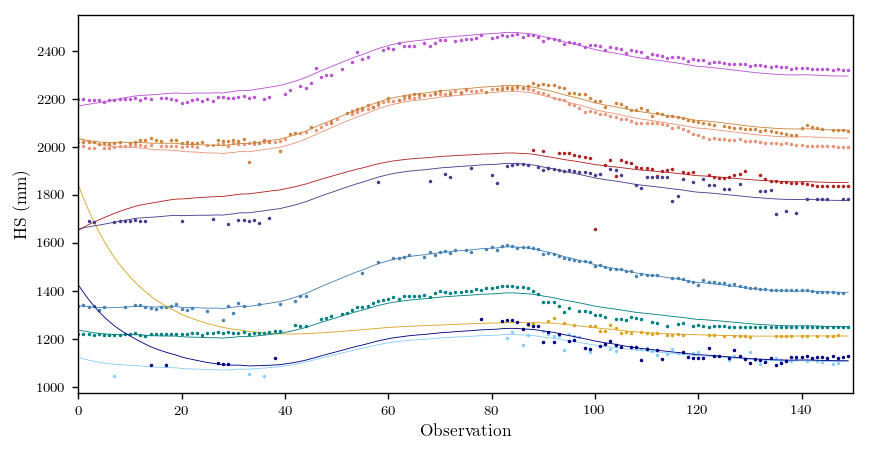

In [11]:
X_hat, sigma_smooth, sigma_filt, pi0, sigma0, As, Bs, Cs, Ds, Qs, Rs = ssm_em_stable(Y, U, V, ss, s_list, n_LF=2, max_it=50)
Y_hat = np.dot(Cs[0], X_hat) + np.dot(Ds[0], V)

plt.figure(figsize=(8, 4))

for s, c in zip(range(len(sensors)), colors):
    plt.plot(Y_hat[s, :], '-', linewidth=0.5, color=c)
    plt.plot(Y[s, :], '.', markersize=2.0, color=c)

plt.xlim(0, tf-ti)
plt.xlabel("Observation")
plt.ylabel("HS (mm)")

### SSM class

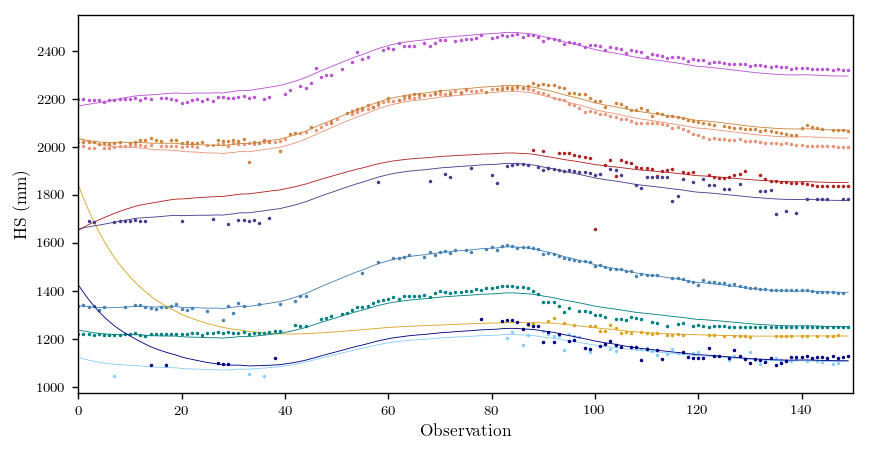

In [14]:
ssm = SSM(y, u, v, ss, s_list, n_LF=2)
ssm.em(num_it=50)
y_hat = ssm.get_y_hat()

plt.figure(figsize=(8, 4))

for s, c in zip(range(len(sensors)), colors):
    plt.plot(y_hat[s, :], '-', linewidth=0.5, color=c)
    plt.plot(y[s, :], '.', markersize=2.0, color=c)

plt.xlim(0, tf-ti)
plt.xlabel("Observation")
plt.ylabel("HS (mm)")